<img src="http://vernonfernandes.net/assets/header_hr.png" width="100%">

An organization is only as good as its best employees. In an ever-changing economy, it is getting harder and harder to retain your best employees. You might be able to offer respectable wages, perks and a great working environment but there will be several other factors that come into play.

You're probably using cutting edge tech and big budgets to make sure your Sales, Marketing, Development, etc. are up to par with industry standards, so why is Human Resources being ignored? Although the cost doesn't appear to be too apparent over financial quarters, there are quite a few hidden costs that accumulate.

Here are just some of the ways in which employee churn can affect your company:

1. **Team Productivity**: Having valuable employees leave can have a major impact on your team morale. This can lead to increased responsibilities for other team members eventually leading to longer hours and team dissatisfaction. If the company culture tends to be bad, this coupled with other factors can also lead to more turnover within your team or department.

1. **Recruitment**: If you're working in a team with a heavy workload and tough schedule, chances are you would need a replacement as soon as possible. This would most definitely cost you and depending on how skilled you want your staff; this can be quiet time intensive.

1. **Training**: This is standard protocol for most companies, training your new employees is crucial. If you happen to hire an employee for a skilled position, you'll probably end up spending quite a bit of time and money training your new hire.

These are just some of the ways in which you could be losing money with your lost employees. This may not seem like a lot but at the end of the day this is an additive issue and if money and time aren't an issue for your company, this can also create a bad public image for your company and its employees.

<img src="http://vernonfernandes.net/assets/quote.png" width="100%">

In [1]:
#Importing all the necessary libraries

import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
import xgboost as xgb

%matplotlib inline

In [2]:
#Importing the libraries to measure metrics on your model

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, learning_curve, train_test_split
from sklearn.metrics import precision_score, roc_auc_score, recall_score, confusion_matrix, roc_curve, precision_recall_curve, accuracy_score

In [3]:
#Ignoring Python warnings

import warnings
warnings.filterwarnings('ignore')

In [4]:
#Loading our IBM HR dataset

df = pd.read_csv('/kaggle/input/ibm-hr-analytics-attrition-dataset/WA_Fn-UseC_-HR-Employee-Attrition.csv')
#df = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')

From the looks of our dataset, it seems like we have a pretty clean dataset with a lot of valuable features to explore.

In [5]:
#Viewing the first 5 rows of our dataset

df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


It looks like there are no null values for our dataset which makes our job a lot easier. This doesn't mean that our work here is done. We will still need to do some analysis in order to get the necessary insight that would be required by our HR department.

<img src="http://vernonfernandes.net/assets/7.png" width="100%">

In [6]:
#Searching for null values in our dataset

pd.DataFrame(df.isna().sum(), columns=['Null Values Present']).T

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
Null Values Present,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Since the dataset did not have any null values, we don't have too much cleaning to do at this stage. This is quite a rare scenario as the chances an employee would skip out on quite a few of these questionnaires is quite high. We can proceed to building a few more features for our DB as this can help make our analysis more rigorous.

In [7]:
#We can create new features to help improve our analysis and aid our machine learning process later on

#Calculating overall satisfaction using pre-existing columns in our DB
df['OverallSatisfaction'] = (df['RelationshipSatisfaction']  
                                  + df['EnvironmentSatisfaction'] 
                                  + df['JobSatisfaction'] 
                                  + df['JobInvolvement'] 
                                  + df['WorkLifeBalance'])/5

#Calculating mean job satisfaction using pre-existing columns in our DB
df['JobSatisf_mean'] = (df['JobSatisfaction'] + df['JobInvolvement']) / 2

#Calculating ratio of monthly income to distance
df['IncomeByDistance'] = df['MonthlyIncome'] / df['DistanceFromHome']

#Calculating employee progress in current company
df['CompanySatisfaction'] = df['YearsInCurrentRole'] / df['YearsAtCompany']


def dis_emp_satdis(df) :
    if df['OverallSatisfaction'] < 2.5 and df['DistanceFromHome'] > 10:
        return 1
    else:
        return 0
df['DisEmpSatDis'] = df.apply(lambda df:dis_emp_satdis(df) ,axis = 1)


def dis_emp(df) :
    if df['OverallSatisfaction'] < 2:
        return 1
    else:
        return 0
df['DisEmp'] = df.apply(lambda df:dis_emp(df) ,axis = 1)


def mar_age(df) :
    if df['MaritalStatus'] == 'Single' and df['Age'] > 35:
        return 1
    else:
        return 0
df['MarAge'] = df.apply(lambda df:mar_age(df) ,axis = 1)


def distance_wlbal(df) : 
    if  df['DistanceFromHome'] > 10 and df['WorkLifeBalance'] < 2 :
        return 1
    else : 
        return 0
df['LongDis_BadWLBal'] = df.apply(lambda df:distance_wlbal(df) ,axis = 1)


def distance(df) : 
    if  df['DistanceFromHome'] > 11:
        return 1
    else : 
        return 0
df['LongDistance'] = df.apply(lambda df:distance(df) ,axis = 1)

def job_inv_sat(df) : 
    if  df['JobInvolvement'] < 2 and df['JobSatisfaction'] < 2:
        return 1
    else : 
        return 0
df['RoleFit'] = df.apply(lambda df:job_inv_sat(df) ,axis = 1)


def job_lvl_ovr(df) : 
    if  df['JobLevel'] == 1 and df['OverTime'] == 1:
        return 1
    else : 
        return 0
df['JobLevelOvertime'] = df.apply(lambda df:job_lvl_ovr(df) ,axis = 1)

def job_lvl_mar(df) : 
    if  df['JobLevel'] == 1 and df['MaritalStatus'] == 'Single':
        return 1
    else : 
        return 0
df['JobLevelMarried'] = df.apply(lambda df:job_lvl_mar(df) ,axis = 1)

We can separate the numerical values as well as the string values into two separate DataFrames. For now, we are separating the numerical values in-order to do some simple exploratory data analysis. Later on, we would need a separated DataFrame to scale our numerical features.

In [8]:
df_int = df.loc[:, df.dtypes == np.int64]

In [9]:
df_int = df_int.drop(['EmployeeCount','StandardHours'], axis = 1)

In [10]:
df_string = df.loc[:, df.dtypes == object]

<img src="http://vernonfernandes.net/assets/3.png" width="100%">

From the heatmap we constructed below, we can see that there are quite a few features that are strongly correlated. We will be doing a more in-depth analysis on this down the line as we familiarize ourselves with the data we have available.

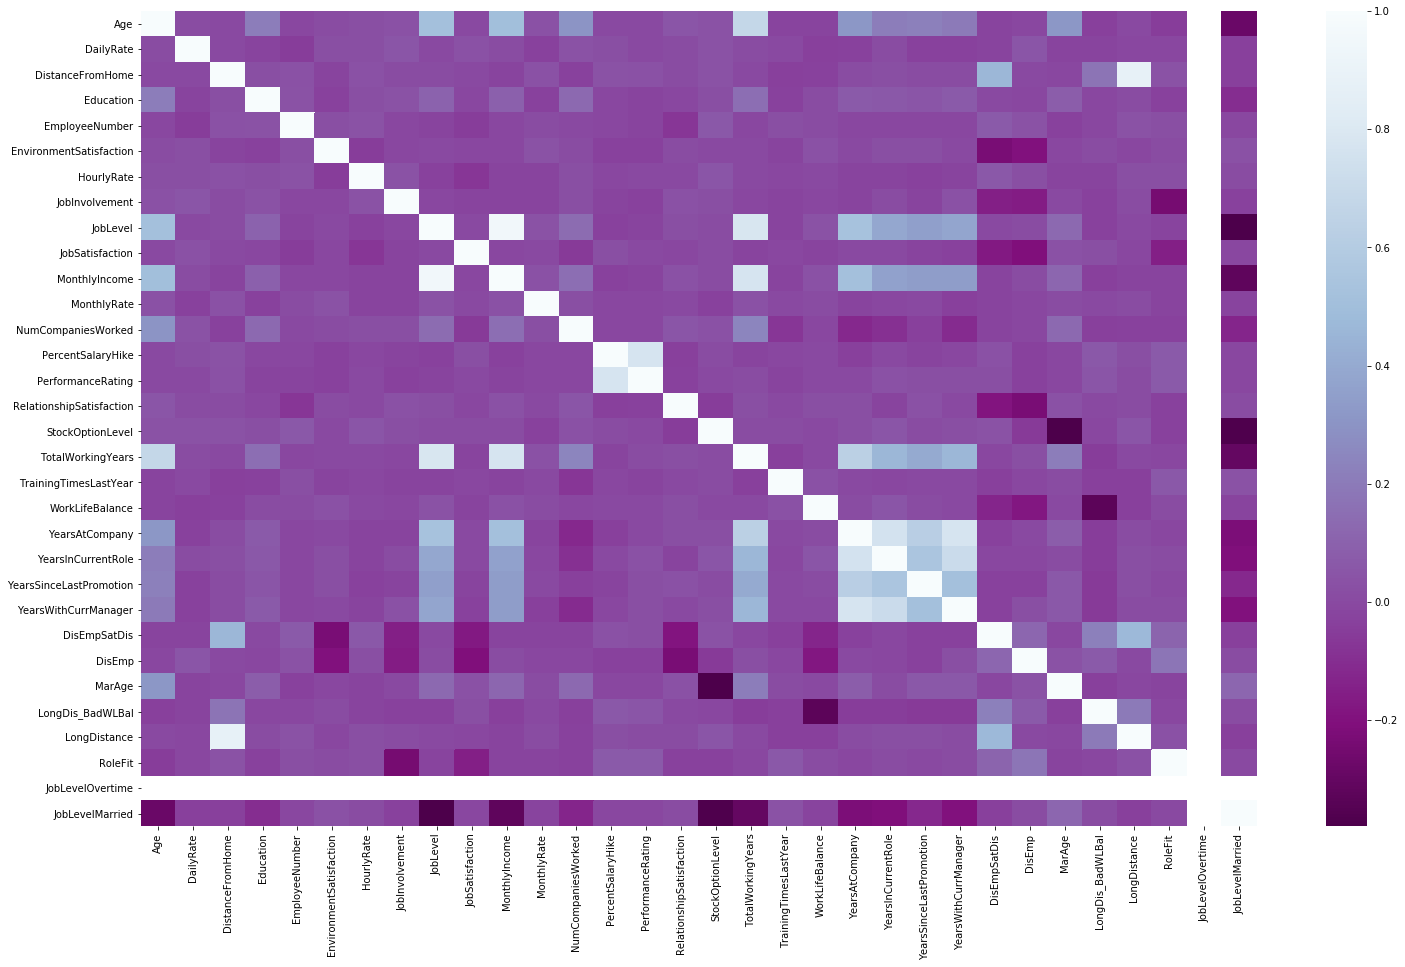

In [11]:
plt.figure(figsize= (25,15))
sns.heatmap(df_int.corr().round(2), cmap="BuPu_r")

In [12]:
df_attrition = pd.DataFrame(df.Attrition.value_counts())

In [13]:
df_attrition['kind'] = df_attrition.index

In [14]:
df_attrition

,Attrition,kind
No,1233,No
Yes,237,Yes


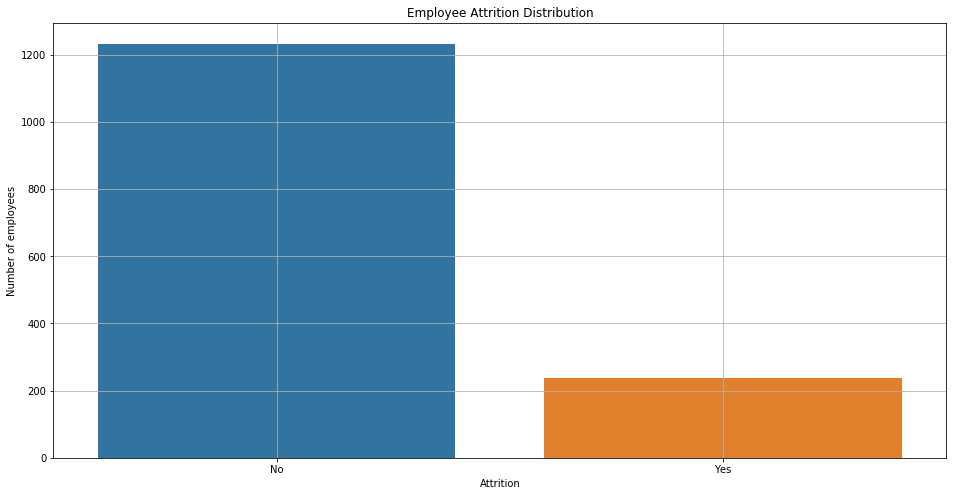

In [15]:
plt.figure(figsize=(16,8))
sns.barplot(x="kind", y="Attrition", data=df_attrition)
plt.title('Employee Attrition Distribution')
plt.xlabel('Attrition')
plt.ylabel('Number of employees')
plt.grid()

Text(0, 0.5, 'Attrition')

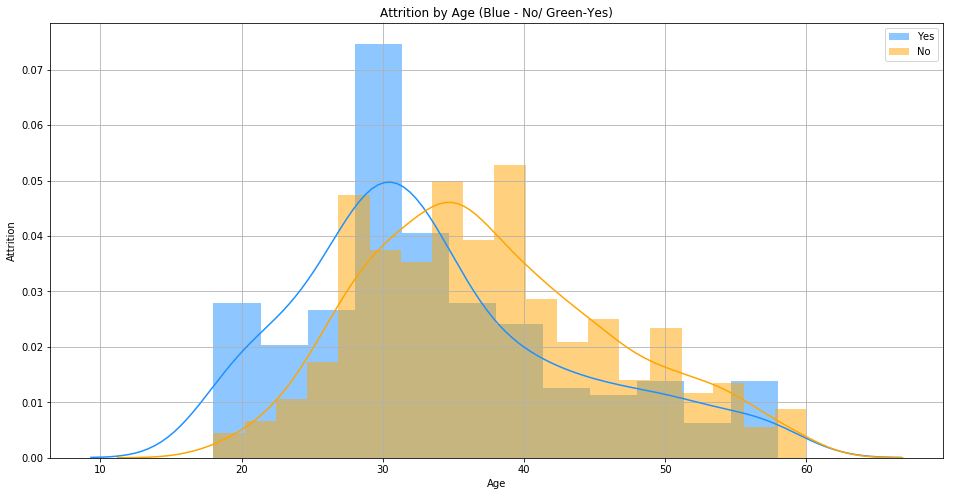

In [16]:
# Sort the dataframe by Age
df_no = df.loc[df['Attrition'] == 'No']
df_yes = df.loc[df['Attrition'] == 'Yes']

plt.figure(figsize=(16,8))
sns.distplot(df_yes[['Age']],color='dodgerblue', label="Yes", hist_kws={'alpha':.5})
sns.distplot(df_no[['Age']], color='orange', label="No", hist_kws={'alpha':.5})
plt.grid()
plt.legend()
plt.title('Attrition by Age (Blue - No/ Green-Yes)')
plt.xlabel('Age')
plt.ylabel('Attrition')

From the above chart, it seems that the lower the age of the employee, the higher the chances are that they might leave.

Text(0, 0.5, 'Attrition')

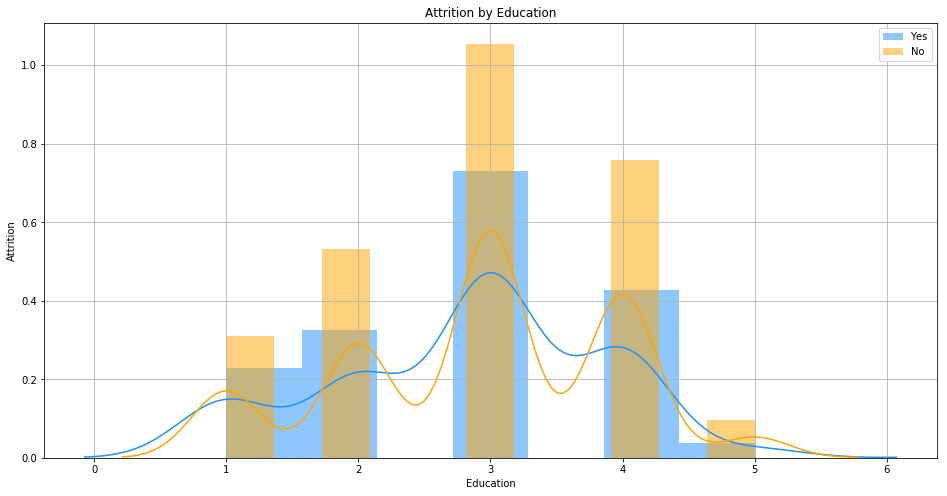

In [17]:
plt.figure(figsize=(16,8))
sns.distplot(df_yes[['Education']],color='dodgerblue', label="Yes", hist_kws={'alpha':.5})
sns.distplot(df_no[['Education']], color='orange', label="No", hist_kws={'alpha':.5})
plt.grid()
plt.title('Attrition by Education')
plt.legend()
plt.xlabel('Education')
plt.ylabel('Attrition')

Text(0, 0.5, 'Attrition')

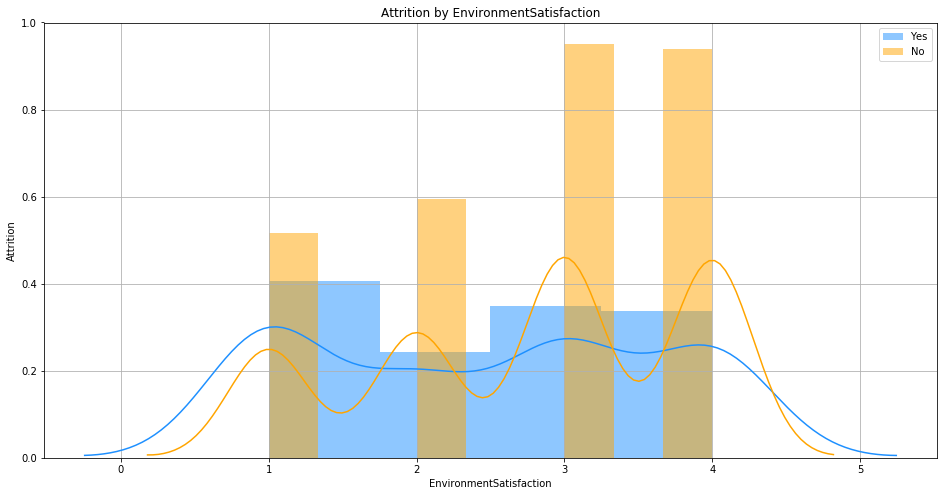

In [18]:
plt.figure(figsize=(16,8))
sns.distplot(df_yes[['EnvironmentSatisfaction']],color='dodgerblue', label="Yes", hist_kws={'alpha':.5})
sns.distplot(df_no[['EnvironmentSatisfaction']], color='orange', label="No", hist_kws={'alpha':.5})
plt.grid()
plt.title('Attrition by EnvironmentSatisfaction')
plt.legend()
plt.xlabel('EnvironmentSatisfaction')
plt.ylabel('Attrition')

Text(0, 0.5, 'Attrition')

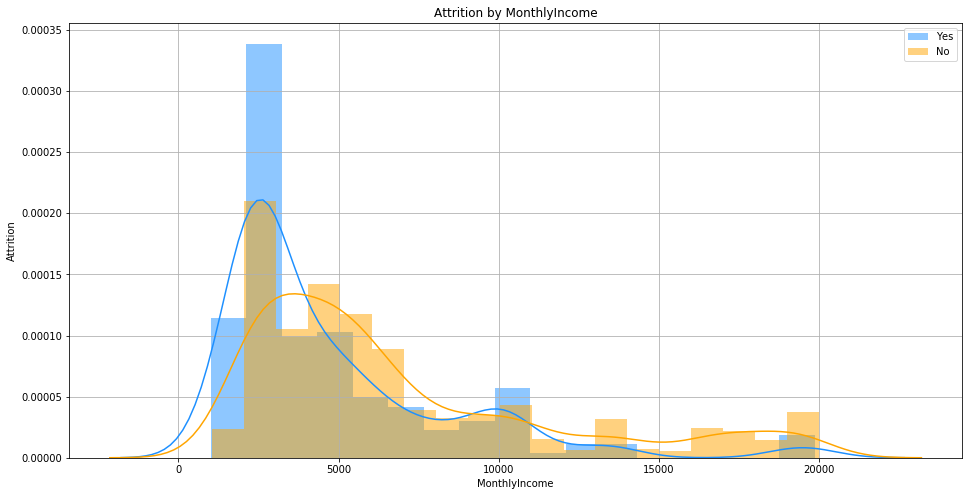

In [19]:
plt.figure(figsize=(16,8))
sns.distplot(df_yes[['MonthlyIncome']],color='dodgerblue', label="Yes", hist_kws={'alpha':.5})
sns.distplot(df_no[['MonthlyIncome']], color='orange', label="No", hist_kws={'alpha':.5})
plt.grid()
plt.title('Attrition by MonthlyIncome')
plt.legend()
plt.xlabel('MonthlyIncome')
plt.ylabel('Attrition')

Text(0, 0.5, 'Attrition')

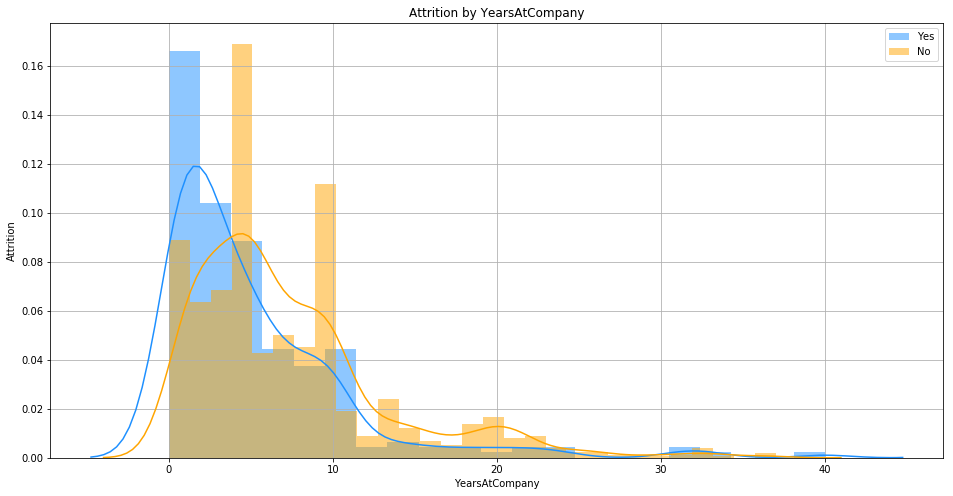

In [20]:
plt.figure(figsize=(16,8))
sns.distplot(df_yes[['YearsAtCompany']],color='dodgerblue', label="Yes", hist_kws={'alpha':.5})
sns.distplot(df_no[['YearsAtCompany']], color='orange', label="No", hist_kws={'alpha':.5})
plt.grid()
plt.title('Attrition by YearsAtCompany')
plt.legend()
plt.xlabel('YearsAtCompany')
plt.ylabel('Attrition')

Text(0, 0.5, 'Attrition')

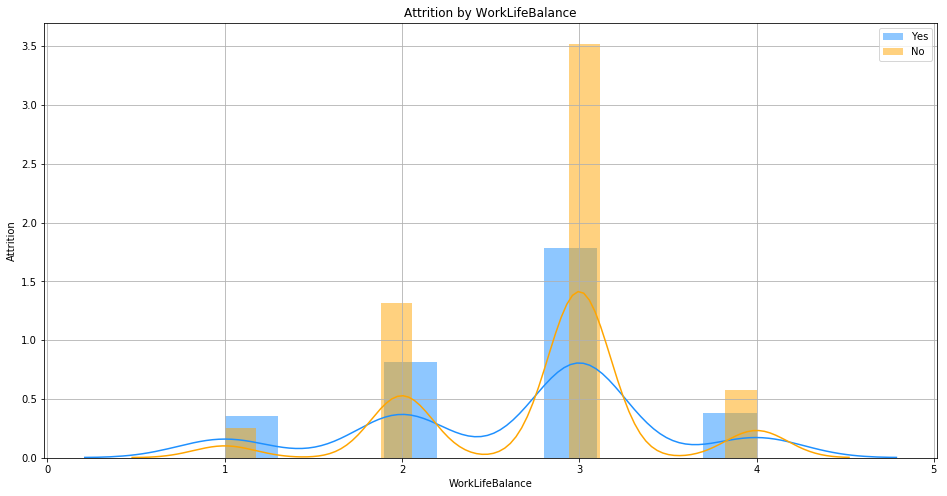

In [21]:
plt.figure(figsize=(16,8))
sns.distplot(df_yes[['WorkLifeBalance']],color='dodgerblue', label="Yes", hist_kws={'alpha':.5})
sns.distplot(df_no[['WorkLifeBalance']], color='orange', label="No", hist_kws={'alpha':.5})
plt.grid()
plt.title('Attrition by WorkLifeBalance')
plt.legend()
plt.xlabel('WorkLifeBalance')
plt.ylabel('Attrition')

Text(0, 0.5, 'Attrition')

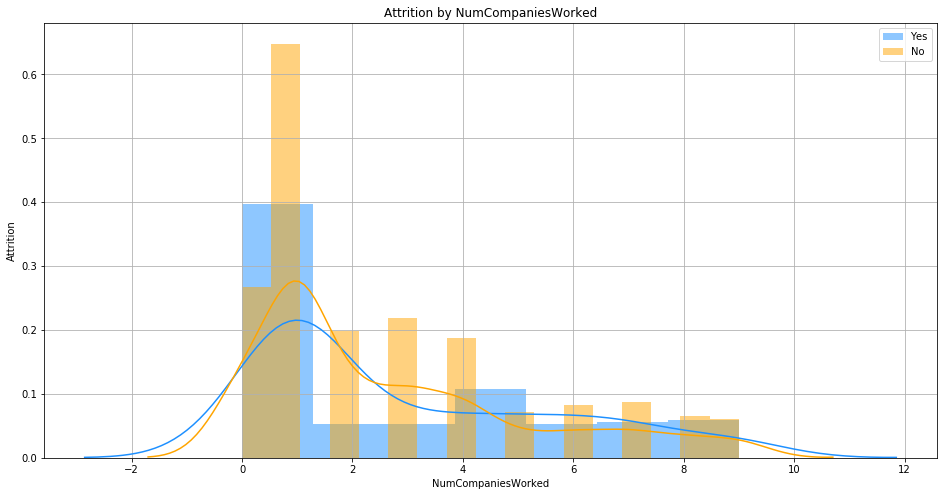

In [22]:
plt.figure(figsize=(16,8))
sns.distplot(df_yes[['NumCompaniesWorked']],color='dodgerblue', label="Yes", hist_kws={'alpha':.5})
sns.distplot(df_no[['NumCompaniesWorked']], color='orange', label="No", hist_kws={'alpha':.5})
plt.grid()
plt.title('Attrition by NumCompaniesWorked')
plt.legend()
plt.xlabel('NumCompaniesWorked')
plt.ylabel('Attrition')

The main take away from the above charts shows that Monthly Income, Year at the company, Environment Satisfaction and Age are strongly correlated with employee attrition.

In [23]:
#Average values for employees that have not left the company and employees that have left
df.groupby(['Attrition']).mean().T

Attrition,No,Yes
Age,37.561233,33.607595
DailyRate,812.504461,750.362869
DistanceFromHome,8.915653,10.632911
Education,2.927007,2.839662
EmployeeCount,1.000000,1.000000
EmployeeNumber,1027.656123,1010.345992
EnvironmentSatisfaction,2.771290,2.464135
HourlyRate,65.952149,65.573840
JobInvolvement,2.770479,2.518987
JobLevel,2.145985,1.637131


<img src="http://vernonfernandes.net/assets/1.png" width="100%">

In [24]:
#Dropping the columns that don't provide much information

df = df.drop(['EmployeeCount','StandardHours','Over18'], axis = 1)

In [25]:
#Dropping the columns that don't provide much information

df_string.drop(['Over18'], axis = 1, inplace= True)

In [26]:
#Creating a new subset dataframe so that we can encode all the categorical variables together

dummy_cat = df_string.drop(['Attrition'], axis = 1)

In [27]:
dummy_cat = pd.get_dummies(dummy_cat)
dummy_cat.head()

,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,...,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
0,0,0,1,0,0,1,0,1,0,0,...,0,0,0,1,0,0,0,1,0,1
1,0,1,0,0,1,0,0,1,0,0,...,0,0,1,0,0,0,1,0,1,0
2,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
3,0,1,0,0,1,0,0,1,0,0,...,0,0,1,0,0,0,1,0,0,1
4,0,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0


In [28]:
#To avoid multicollinearity, we would need to remove one variable each for all categorical columns

dummy_cat.drop(['BusinessTravel_Non-Travel',
               'Department_Human Resources',
               'EducationField_Human Resources',
               'Gender_Female',
               'JobRole_Healthcare Representative',
               'MaritalStatus_Divorced',
               'OverTime_No',],axis = 1, inplace=True)

In [29]:
#We've separated the columns with binary values from the continuous values, we do this so that we can scale the continuous values separately without affecting

df_binary = df.loc[:,['MarAge','LongDis_BadWLBal','LongDistance','RoleFit','JobLevelOvertime','JobLevelMarried','DisEmpSatDis','DisEmp']]

In [30]:
#REmoving the binary columns from the data frame that holds the numerical columns

df_int.drop(['MarAge',
               'LongDis_BadWLBal',
               'LongDistance',
               'RoleFit',
               'JobLevelOvertime',
               'JobLevelMarried',
               'DisEmpSatDis',
               'DisEmp'],axis = 1, inplace=True)

In [31]:
#Combining the binary columns and categorical columns

df_final = pd.concat([df_binary, dummy_cat], axis=1)

In [32]:
#Converting the Employee Attrition column to numrical values

df.Attrition.replace(to_replace = dict(Yes = 1, No = 0), inplace = True)

In [33]:
df_int.drop(['EmployeeNumber'], axis =1, inplace=True)

Now we have df_int which needs to be scaled and we have df_final which is the final DataFrame that has all the dummy variables as well as the new binary variables that we created.

In [34]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
scaled_df_int = std.fit_transform(df_int)
scaled_df_int = pd.DataFrame(scaled_df_int, columns=df_int.columns)

In [35]:
#Once we've scaled the numerical columns, we can now combine our final dataframe and the scaled dataframes

df_final = pd.concat([scaled_df_int, df_final], axis=1)

In [36]:
#Creating out target variable

y = df[['Attrition']]

In [37]:
#Our final set of features

X = df_final

In [38]:
# Threshold for removing correlated variables
threshold = 0.8

# Absolute value correlation matrix
corr_matrix = X.corr().abs()
corr_matrix.head()

# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()

# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

In [39]:
#Dropping columns with strong correlation

X = X.drop(columns = to_drop)

In [40]:
#Dividing out DF into train and test sets

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state = 0)

<img src="http://vernonfernandes.net/assets/xgboost.png" width="100%">

In [41]:
classifier1 = xgb.XGBClassifier(n_jobs = -1)

# A parameter grid for XGBoost
params = {
        'n_estimators' : [100, 400, 500, 700, 800],
        'learning_rate' : [0.01, 0.01, 0.05, 0.1, 0.25, 0.5],
        'min_child_weight': [1, 2, 4, 5, 7, 9, 13],
        'gamma': [0.1, 0.5, 1, 1.5, 5],
        'subsample': [0.5, 0.7, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [2, 4, 6, 8, 10, 12]
        }

folds = 5
random_search = RandomizedSearchCV(classifier1, param_distributions=params, n_iter=800, scoring='accuracy', n_jobs=-1, cv=5, verbose=3, random_state=42)


In [42]:
# and now we train over all the possible combinations of the parameters above
#random_search.fit(X_train, y_train)

# and we print the best score over the train set
#print(("best roc-auc from grid search: %.3f"
#       % random_search.score(X_train, y_train)))
#best roc-auc from grid search: 0.941

In [43]:
# we can print the best estimator parameters like this
#random_search.best_estimator_
#XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
#              colsample_bynode=1, colsample_bytree=0.6, gamma=0.1, gpu_id=-1,
#              importance_type='gain', interaction_constraints=None,
#              learning_rate=0.05, max_delta_step=0, max_depth=2,
#              min_child_weight=2, missing=nan, monotone_constraints=None,
#              n_estimators=500, n_jobs=-1, num_parallel_tree=1,
#              objective='binary:logistic', random_state=0, reg_alpha=0,
#              reg_lambda=1, scale_pos_weight=1, subsample=0.5, tree_method=None,
#              validate_parameters=False, verbosity=None)

In [44]:
# and find the best fit parameters like this
#random_search.best_params_

In [45]:
#Fitting our Train data to our XGB classifier with the best possible parameters

xgb_classifier = xgb.XGBClassifier(base_score=0.5, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0.1,
              importance_type='gain',
              learning_rate=0.05, max_delta_step=0, max_depth=2,
              min_child_weight=2,
              n_estimators=500, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.5,
              validate_parameters=False)

xgb_classifier.fit(X_train, y_train)
y_pred = xgb_classifier.predict(X_test)
y_prob = xgb_classifier.predict_proba(X_test)[:,1]

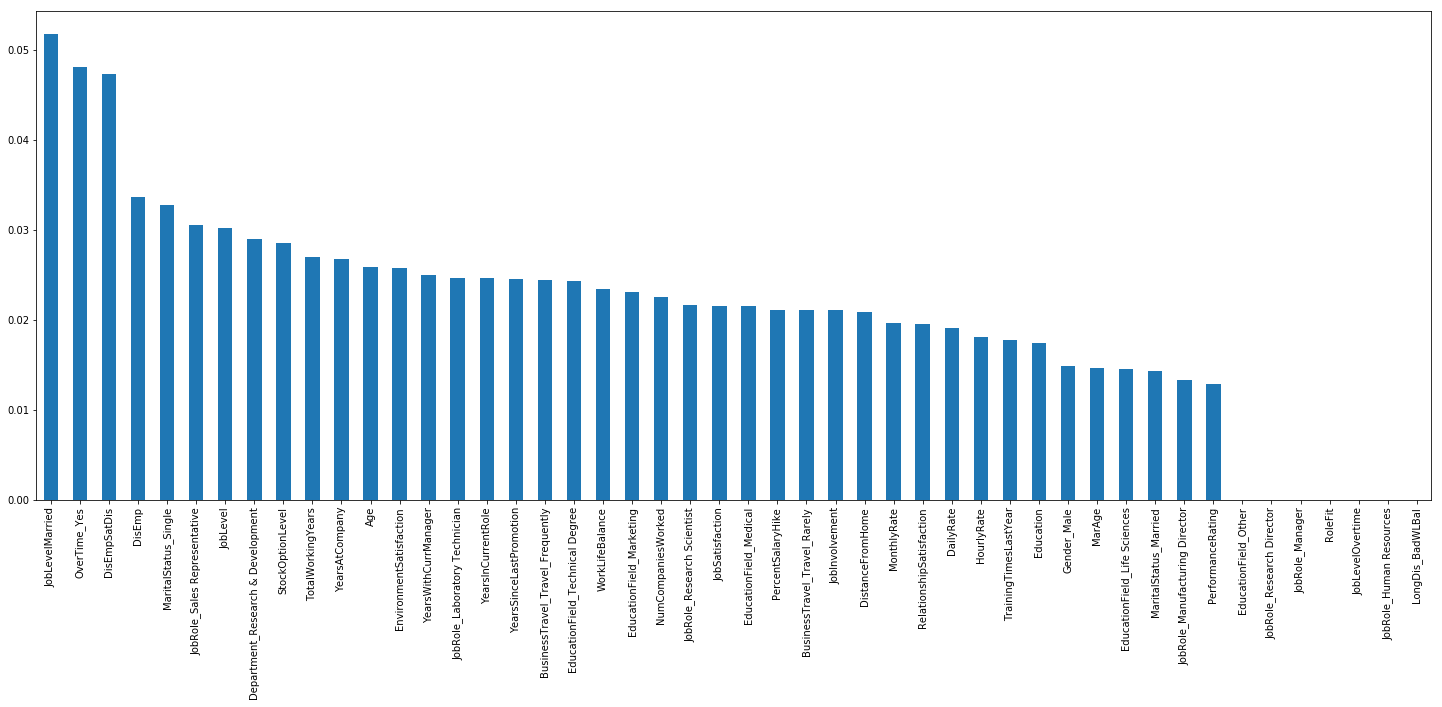

In [46]:
# let's explore the importance of the features

importance = pd.Series(xgb_classifier.feature_importances_)
importance.index = X.columns
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(25,9))

In [47]:
from sklearn.metrics import classification_report,confusion_matrix

In [48]:
print('---'*20)
print('Cross Validation Scores For the XGBoost Classifier')
print('---'*20)
print('Accuracy : ' + str(cross_val_score(xgb_classifier, X, y, cv = 5, scoring = 'accuracy').mean()))
print('Precision : ' + str(cross_val_score(xgb_classifier, X, y, cv = 5, scoring = 'precision').mean()))
print('Recall : ' + str(cross_val_score(xgb_classifier, X, y, cv = 5, scoring = 'recall').mean()))
print('---'*20)
print('Confusion Matrix For the XGBoost Classifier')
print('---'*20)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print('---'*20)
print('Classification Report For the XGBoost Classifier')
print('---'*20)
print(classification_report(y_test,y_pred))

------------------------------------------------------------
Cross Validation Scores For the XGBoost Classifier
------------------------------------------------------------
Accuracy : 0.8795918367346939
Precision : 0.7505930735930736
Recall : 0.3802304964539007
------------------------------------------------------------
Confusion Matrix For the XGBoost Classifier
------------------------------------------------------------
[[365   6]
 [ 44  26]]
------------------------------------------------------------
Classification Report For the XGBoost Classifier
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.98      0.94       371
           1       0.81      0.37      0.51        70

    accuracy                           0.89       441
   macro avg       0.85      0.68      0.72       441
weighted avg       0.88      0.89      0.87       441



<img src="http://vernonfernandes.net/assets/rfc.png" width="100%">

In [49]:
from sklearn.ensemble import RandomForestClassifier

In [50]:
rfc = RandomForestClassifier(n_estimators=600)

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]


# A parameter grid for XGBoost
params = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

folds = 5
random_search_rfc = RandomizedSearchCV(rfc, param_distributions=params, n_iter=800, scoring='accuracy', n_jobs=-1, cv=5, verbose=3, random_state=42)


In [51]:
# and now we train over all the possible combinations of the parameters above
#random_search_rfc.fit(X_train, y_train)

In [52]:
# and we print the best score over the train set
#random_search_rfc.score(X_train, y_train)
#0.9203109815354713

In [53]:
# we can print the best estimator parameters like this
#random_search_rfc.best_estimator_
#RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
#                       max_depth=90, max_features='sqrt', max_leaf_nodes=None,
#                       min_impurity_decrease=0.0, min_impurity_split=None,
#                       min_samples_leaf=2, min_samples_split=10,
#                       min_weight_fraction_leaf=0.0, n_estimators=100,
#                       n_jobs=None, oob_score=False, random_state=None,
#                       verbose=0, warm_start=False)

In [54]:
# and find the best fit parameters like this
#random_search_rfc.best_params_
#{'n_estimators': 100,
# 'min_samples_split': 10,
# 'min_samples_leaf': 2,
# 'max_features': 'sqrt',
# 'max_depth': 90,
# 'bootstrap': True}

In [55]:
rfc_classifier = RandomForestClassifier(bootstrap=True, criterion='gini',
                       max_depth=90, max_features='sqrt',
                       min_impurity_decrease=0.0,
                       min_samples_leaf=2, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       oob_score=False,
                       verbose=0, warm_start=False)

rfc_classifier.fit(X_train, y_train)
y_pred_rfc = rfc_classifier.predict(X_test)

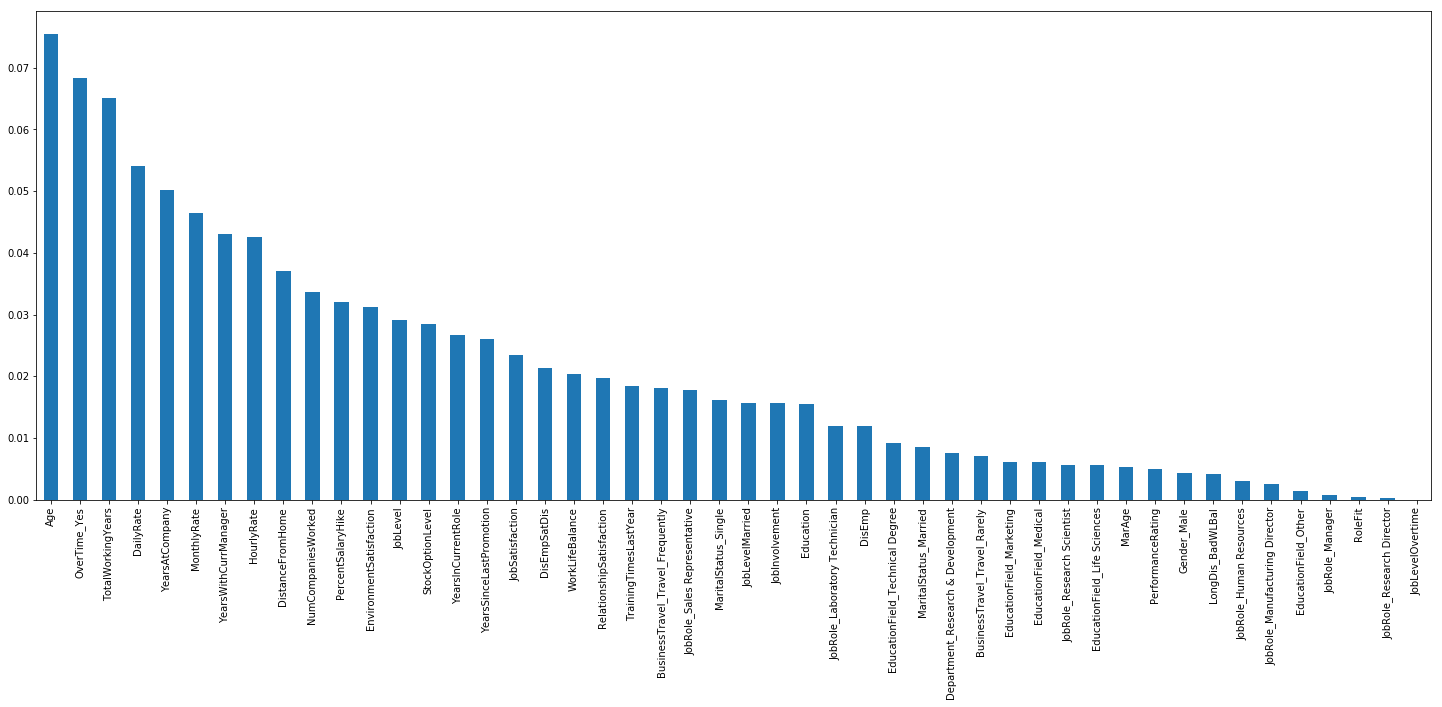

In [56]:
# let's explore the importance of the features

importance = pd.Series(rfc_classifier.feature_importances_)
importance.index = X.columns
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(25,9))

In [57]:
print('---'*20)
print('Cross Validation Scores For the Random Forest Classifier')
print('---'*20)
print('Accuracy : ' + str(cross_val_score(rfc_classifier, X, y, cv = 5, scoring = 'accuracy').mean()))
print('Precision : ' + str(cross_val_score(rfc_classifier, X, y, cv = 5, scoring = 'precision').mean()))
print('Recall : ' + str(cross_val_score(rfc_classifier, X, y, cv = 5, scoring = 'recall').mean()))
print('---'*20)
print('Confusion Matrix For the Random Forest Classifier')
print('---'*20)
cm_rfc = confusion_matrix(y_test, y_pred_rfc)
print(cm_rfc)
print('---'*20)
print('Classification Report For the Random Forest Classifier')
print('---'*20)
print(classification_report(y_test,y_pred_rfc))

------------------------------------------------------------
Cross Validation Scores For the Random Forest Classifier
------------------------------------------------------------
Accuracy : 0.8530612244897957
Precision : 0.8197619047619048
Recall : 0.13927304964539006
------------------------------------------------------------
Confusion Matrix For the Random Forest Classifier
------------------------------------------------------------
[[370   1]
 [ 60  10]]
------------------------------------------------------------
Classification Report For the Random Forest Classifier
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      1.00      0.92       371
           1       0.91      0.14      0.25        70

    accuracy                           0.86       441
   macro avg       0.88      0.57      0.59       441
weighted avg       0.87      0.86      0.82       441



<img src="http://vernonfernandes.net/assets/scores.png" width="100%">

<img src="http://vernonfernandes.net/assets/5.png" width="100%">